In [2]:
import pandas as pd
import numpy as np
import rapid_review as rr
import os
import matplotlib.pyplot as plt
import importlib
from sklearn.svm import SVC, OneClassSVM

## Pull the document metadata from the xml files from the Pubmed API

In [3]:
document_index = None

for fpath in os.listdir('../data/'):
    if "cohen_all" in fpath:
        ndf = rr.parse_pmxml(f'../data/{fpath}')
    if document_index is None:
        document_index = ndf
    else:
        document_index = pd.concat([document_index,ndf])
        
document_index = document_index.drop_duplicates()
print(document_index.shape)
document_index.head()

(17238, 3)


,PMID,ab,ti
0,9793700,"This randomized, double-blind, placebo-control...",Effect of subcutaneous naratriptan on forearm ...
1,9793701,A multicenter test was conducted to investigat...,Effect of operationalized computer diagnosis o...
2,9793702,Subcutaneous injection of sumatriptan is an ef...,Sumatriptan nasal spray (20 mg/dose) in the ac...
3,9793771,The efficacy and adverse effects of 0.25% apra...,The effect of 0.25% apraclonidine in preventin...
4,9793807,To determine if an intravenous (i.v.) fluid bo...,An intravenous fluid bolus is not necessary be...


## Load the cohen database of SRs
https://dmice.ohsu.edu/cohenaa/systematic-drug-class-review-data.html

In [4]:
cohen_db = pd.read_csv(
    '../data/epc-ir.clean.tsv',
    sep='\t',header=None,
    names=["review","EID","PMID","relevant","fulltext_relevant"]
)

cohen_db['relevant'] = np.where(cohen_db['relevant']=="I",1,0)
cohen_db = cohen_db[["review","PMID","relevant"]]

cohen_db.head()



,review,PMID,relevant
0,ACEInhibitors,10024335,0
1,ACEInhibitors,10027665,0
2,ACEInhibitors,10027935,0
3,ACEInhibitors,10028936,0
4,ACEInhibitors,10029645,1


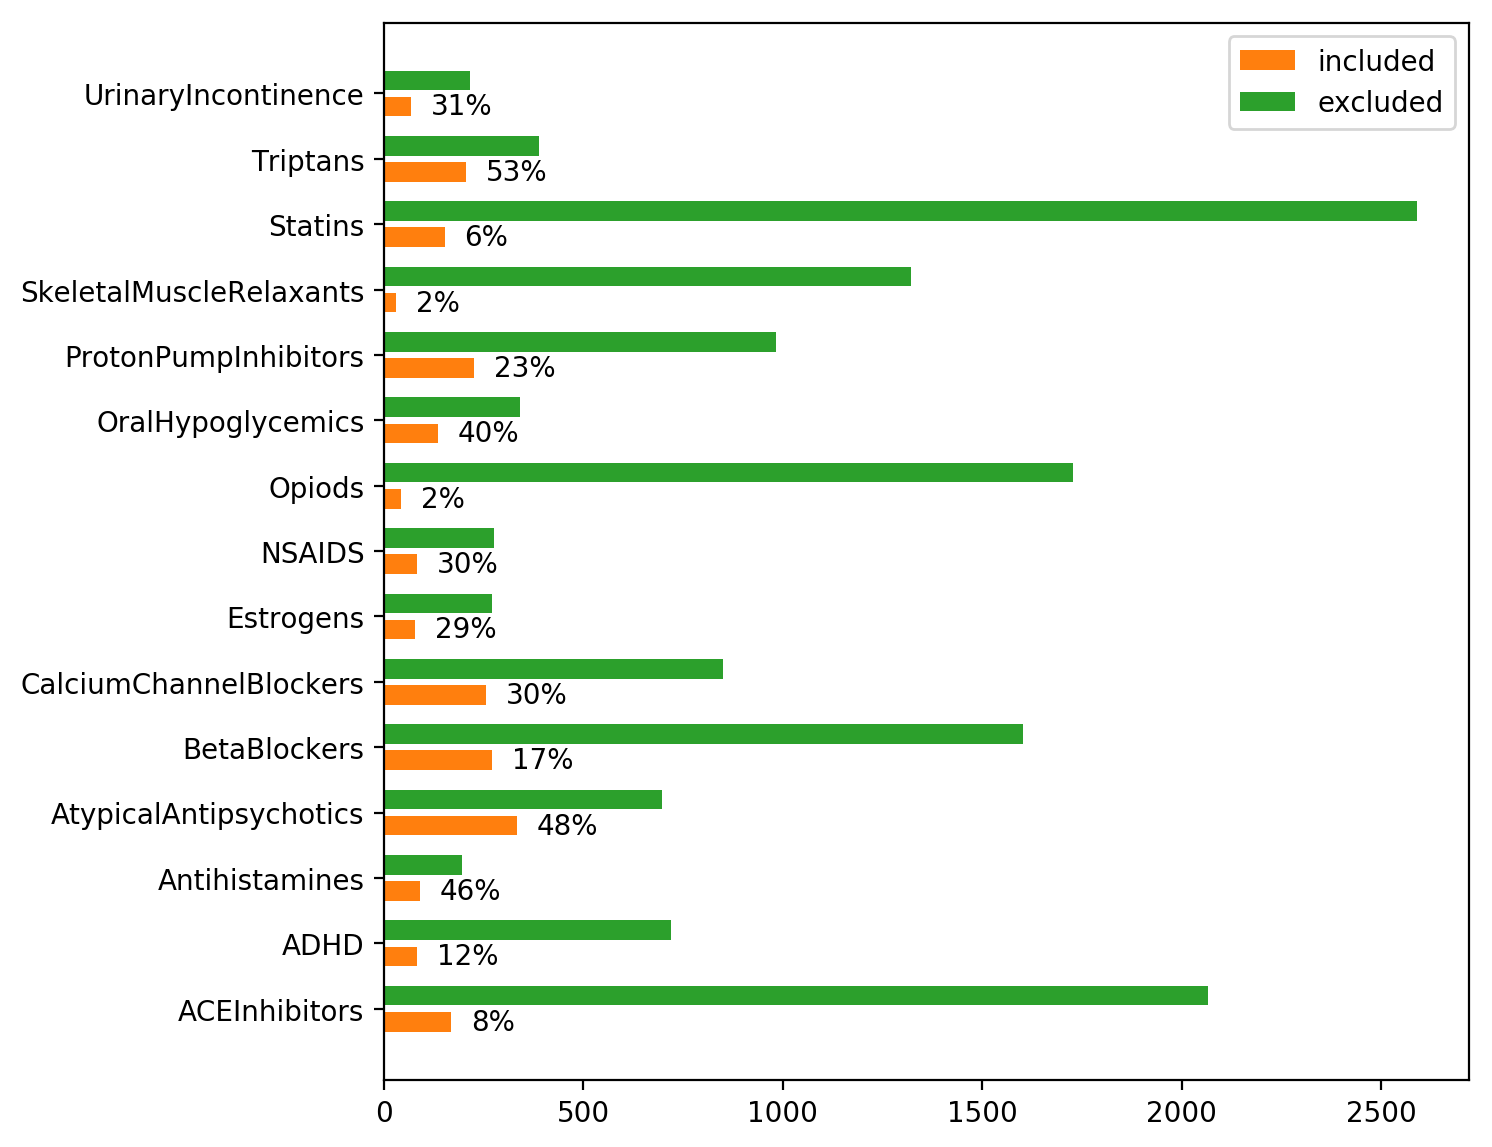

In [5]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)

cm = plt.cm.RdYlBu


ticklabels = []
for i, (name, group) in enumerate(cohen_db.groupby('review')):
    if i==0:
        l1="included"
        l2="excluded"
    else:
        l1 = None
        l2 = None
        
    group = pd.merge(
        group,
        document_index,
    )
    group = group.dropna()
    included = group[group['relevant']==1].shape[0]
    excluded = group[group['relevant']==0].shape[0]
    ax.barh(i-0.2, included, height=0.3, color='C1',label=l1)
    ax.barh(i+0.2, excluded, height=0.3, color='C2', label=l2)
    ax.text(included+50, i-0.2, f'{included/excluded:.0%}', ha="left", va="center")
    ticklabels.append(name)
        
ax.set_yticks([i for i,v in enumerate(ticklabels)])
ax.set_yticklabels(ticklabels)

ax.legend()
    
    
plt.show()

In [128]:
importlib.reload(rr)

models = [
    SVC(kernel='linear',C=5,probability=True)
]
iterations = 2

results = []
rs_results = []
paths = []
for name, group in cohen_db.groupby('review'):
    df = pd.merge(
        group,
        document_index,
    )
    df = df.dropna().reset_index(drop=True)
    if df.shape[0] > 1000:
        continue
    ss = rr.ScreenScenario(
        df, models, 100, 50, name
    )
    for i in range(iterations):
        print(i)
        rs_results.append(ss.screen(i, True))
        results.append(ss.screen(i))
        paths.append({
            "dataset": name,
            "work_path": ss.work_track,
            "recall_path": ss.recall_track
        })

results_df = pd.DataFrame.from_dict(results)
rs_results_df = pd.DataFrame.from_dict(rs_results)
rs_results_df.to_csv('../results/rs_results.csv', index=False)
results_df.to_csv('../results/results.csv', index=False)
print(results_df.shape)
results_df.head()

Dataset: Antihistamines, iteration 1.  150 out of 287 documents seen


KeyboardInterrupt: 

In [129]:
results_df = pd.DataFrame.from_dict(results)
rs_results_df = pd.DataFrame.from_dict(rs_results)

rs_results_df.head()

,dataset,iteration,random_start_recall,random_start_work,recall_pf,recall_rs,s,wss95_pf,wss95_rs
0,ADHD,0,0.771084,0.249066,0.951807,1.000000,100,0.205479,0.098381
1,ADHD,1,0.855422,0.311333,0.951807,0.987952,100,0.339975,0.127024
2,Antihistamines,0,0.577778,0.522648,0.955556,0.955556,100,0.059233,0.041812


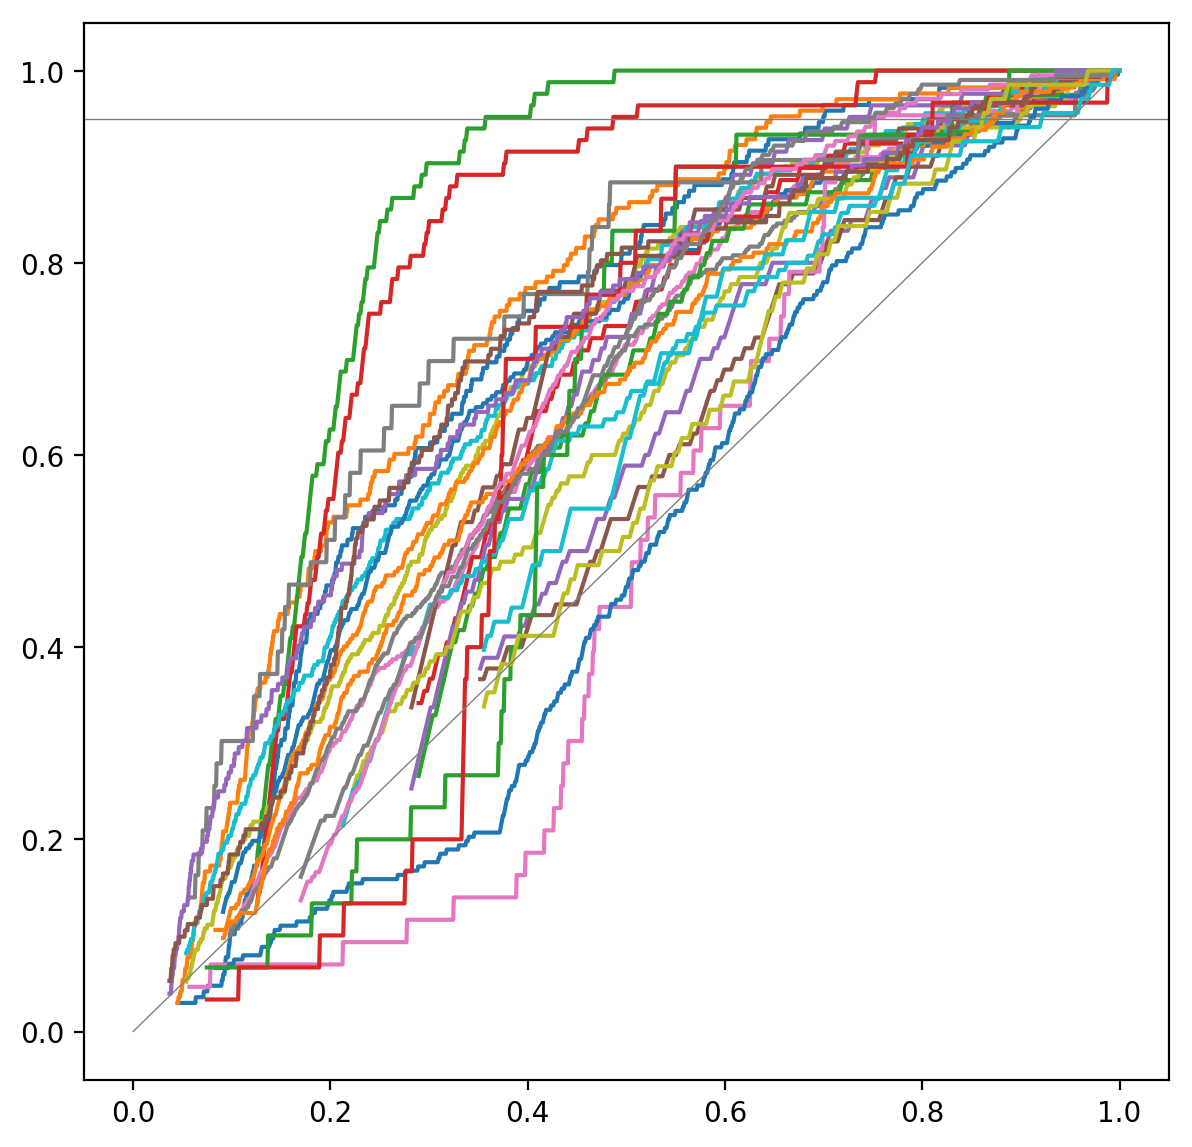

In [81]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
for p in paths:
    ax.plot(p['work_path'],p['recall_path'])
    
    
ax.axhline(0.95, color="grey",lw=0.5)
ax.plot([0,1],[0,1], color="grey", lw=0.5)

plt.show()

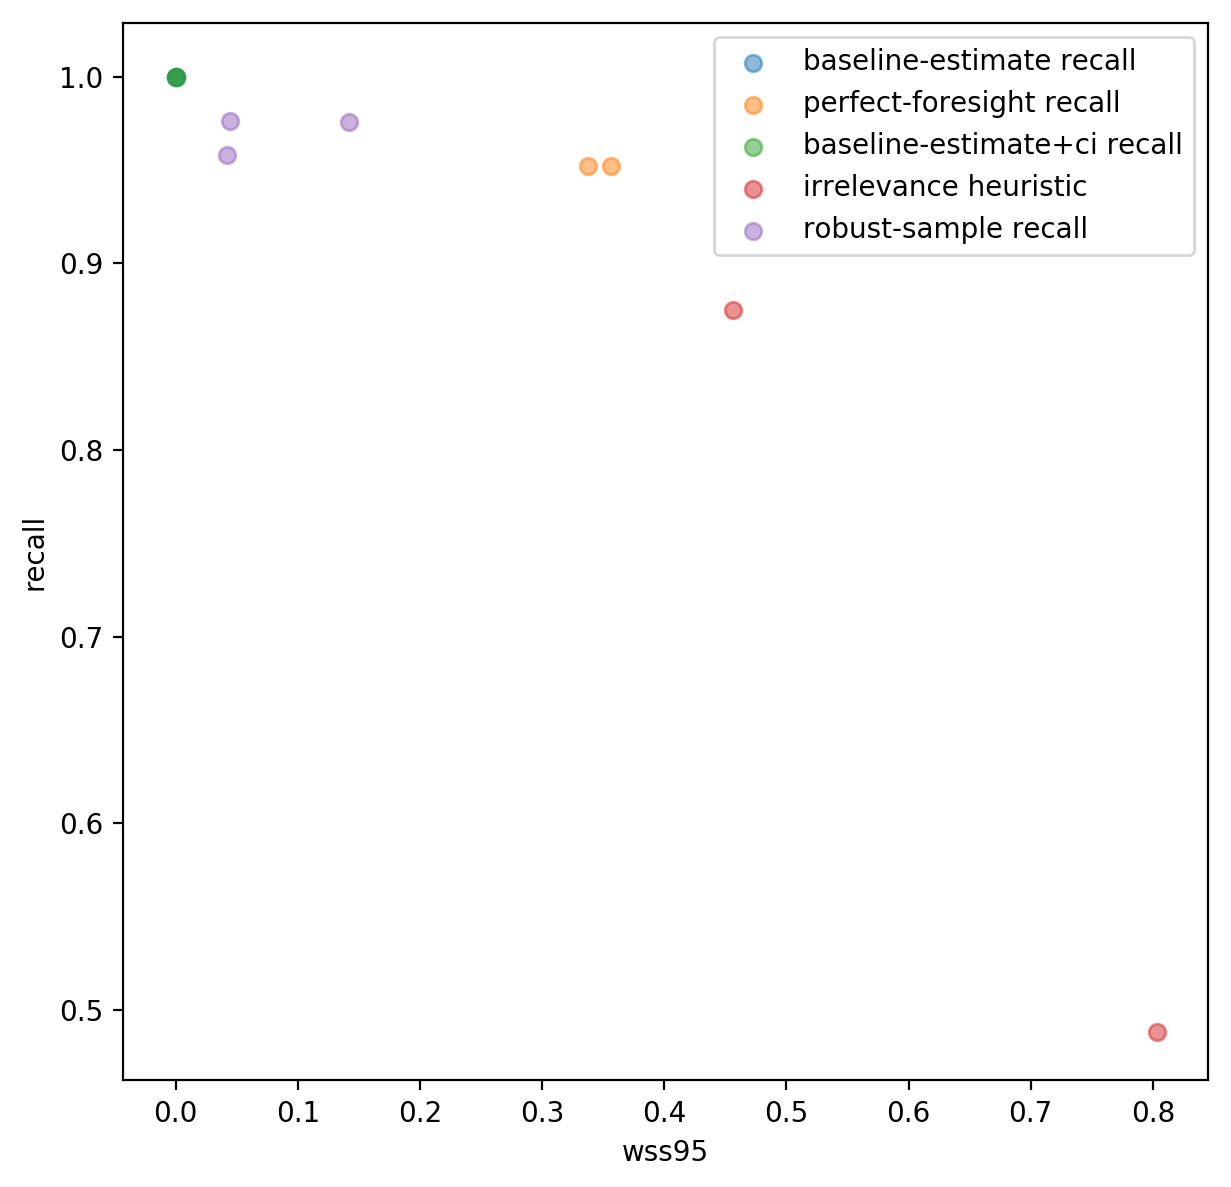

In [125]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.scatter(
    results_df['wss95_bir'], results_df['recall_bir'], 
    alpha=0.5, 
    label="baseline-estimate recall"
)
ax.scatter(
    results_df['wss95_pf'], 
    results_df['recall'], 
    alpha=0.5,
    label="perfect-foresight recall"
)

ax.scatter(
    results_df['wss95_bir_ci'], 
    results_df['recall_bir_ci'], 
    alpha=0.5,
    label="baseline-estimate+ci recall"
)

ax.scatter(
    results_df['wss95_ih'], 
    results_df['recall_ih'], 
    alpha=0.5,
    label="irrelevance heuristic"
)

ax.scatter(
    rs_results_df['wss95_rs'], rs_results_df['recall_rs'], 
    alpha=0.5, 
    label="robust-sample recall"
)

ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')
plt.show()

In [ ]:
r

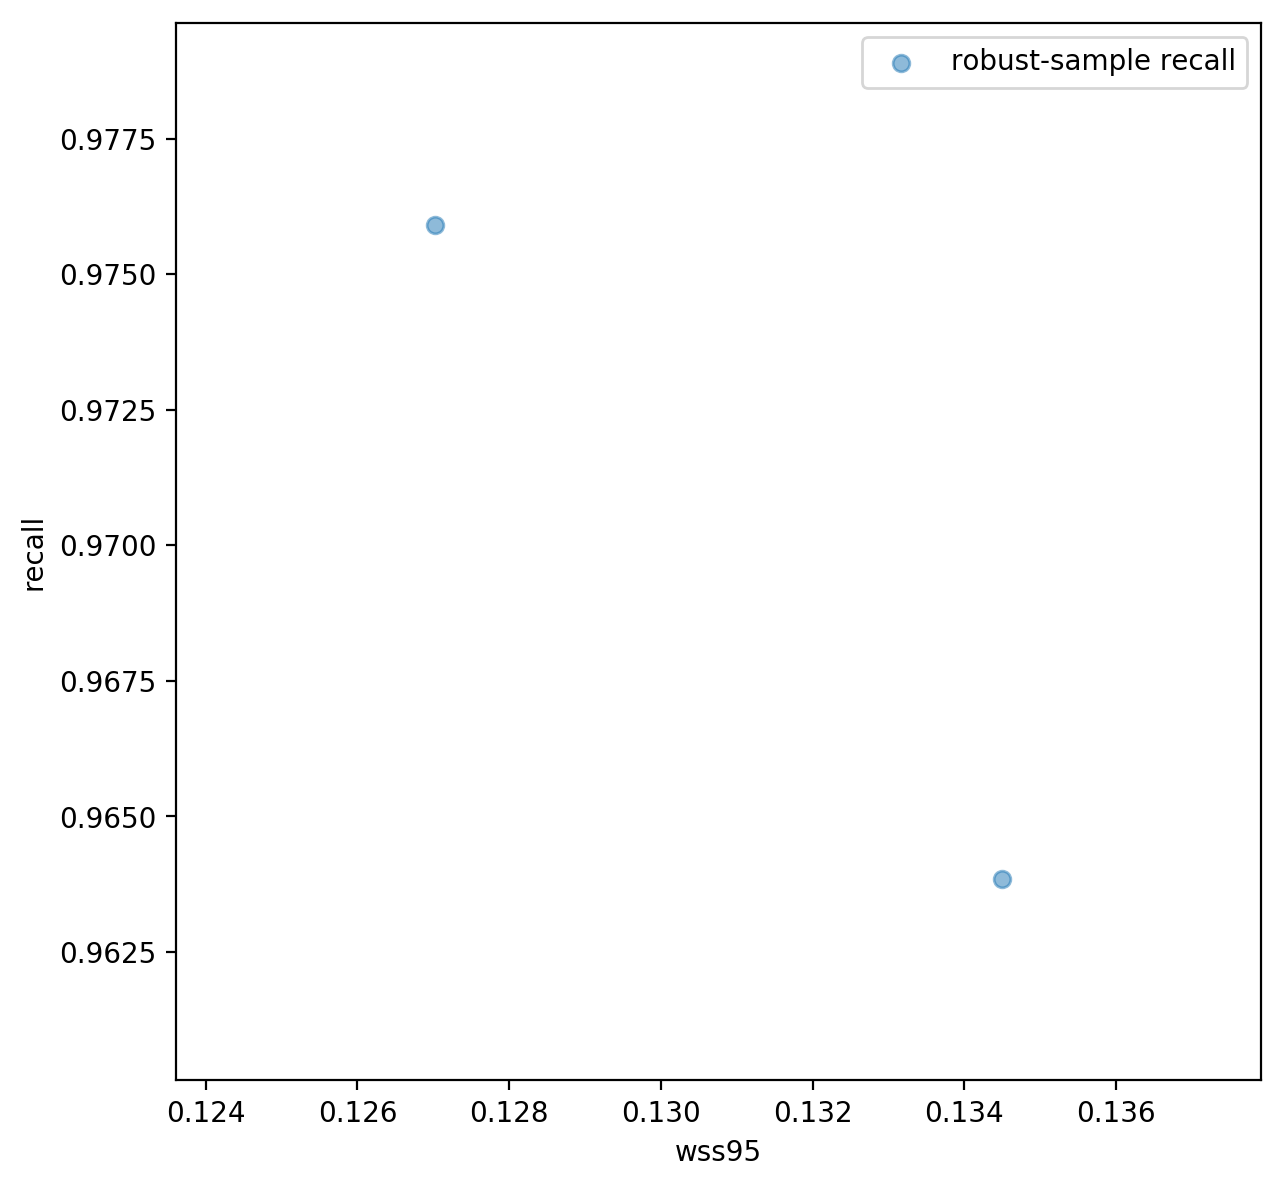

In [112]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.scatter(
    rs_results_df['wss95_rs'], rs_results_df['recall_rs'], 
    alpha=0.5, 
    label="robust-sample recall"
)


ax.legend()
ax.set_ylabel('recall')
ax.set_xlabel('wss95')
plt.show()

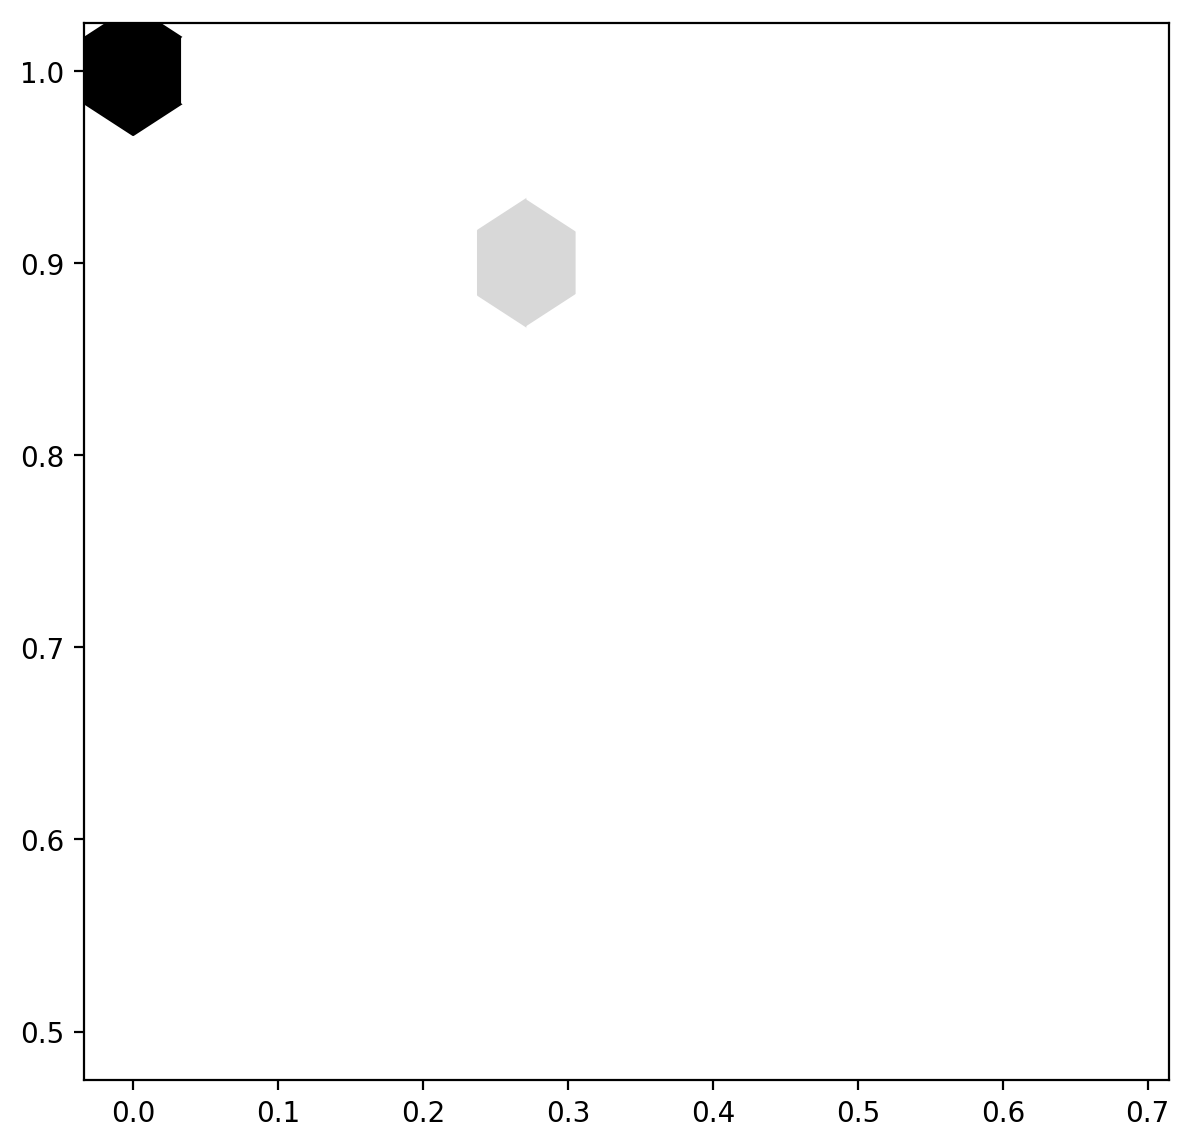

In [95]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.hexbin(
    results_df['wss95_bir'], 
    results_df['recall_bir'], 
    gridsize=10, 
    mincnt=1,
    bins="log",
    cmap = "Greys"
)
plt.show()

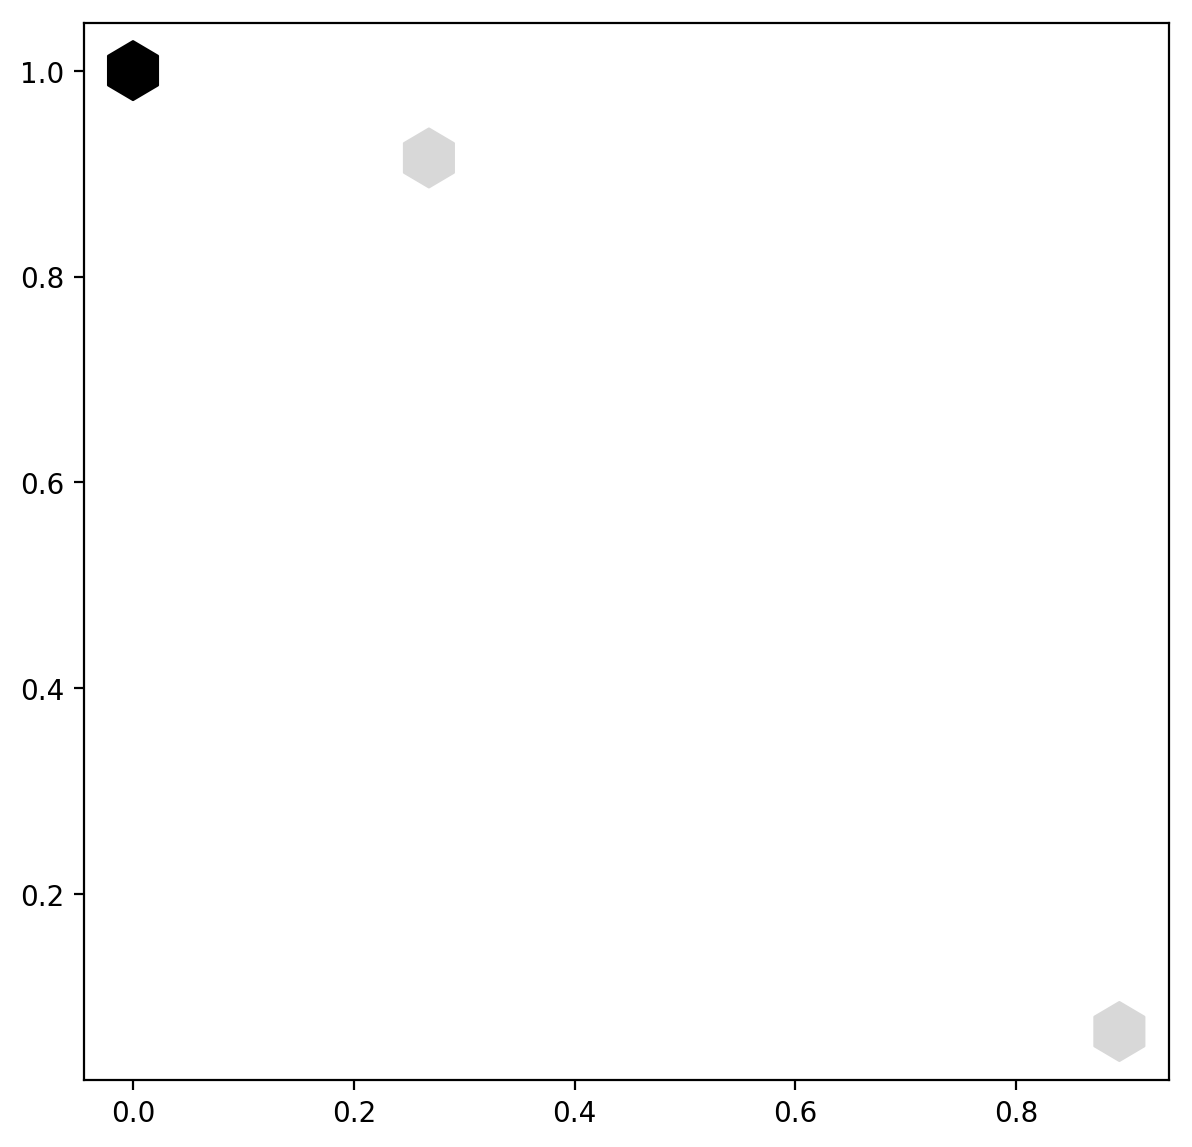

In [96]:
fig, ax = plt.subplots(figsize=(7,7),dpi=200)
ax.hexbin(
    results_df['wss95_ih'], 
    results_df['recall_ih'], 
    gridsize=20, 
    mincnt=1,
    cmap="Greys",
    bins="log"
)
plt.show()